In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# testing some code

In [2]:
name = '0a148697c.jpg'
labels_file =  "../data/labels/boxes_v2.csv"

In [3]:
y_raw = pd.read_csv(labels_file)
y_raw.head(2)

,ImageId,width,height,lt_x,lt_y,rb_x,rb_y
0,00003e153.jpg,0,0,0,0,0,0
1,0001124c7.jpg,0,0,0,0,0,0


In [32]:
y_raw[y_raw.ImageId==name]

,ImageId,width,height,lt_x,lt_y,rb_x,rb_y
9180,0a148697c.jpg,26,38,557,473,583,511
9181,0a148697c.jpg,150,44,1,715,151,759
9182,0a148697c.jpg,26,36,575,445,601,481
9183,0a148697c.jpg,82,132,685,507,767,639
9184,0a148697c.jpg,23,30,593,418,616,448
9185,0a148697c.jpg,97,140,451,550,548,690


In [4]:
def get_y_data(y_raw, filename):
    '''
    Converts a filename into an array, with one channel for each boat in the image
    :param filename: filename string
    :return: np array of size [h, w, n_boats_in_this_image]
    '''
    ground_truths = y_raw[y_raw.ImageId == filename]
    array_of_coords = np.array(ground_truths[['lt_x', 'lt_y', 'rb_x', 'rb_y']])
    # array_of_coords is of shape [n_boxes, 4]

    n_boxes = array_of_coords.shape[0]
    y_map = np.zeros((768, 768, n_boxes))

    for box_idx in range(n_boxes):
        # Loop over amount of boats per image ~ of order 10.
        box = array_of_coords[box_idx, :]
        # TODO: check that im using dimensions correctly here and agrees with static file
        y_map[box[0]:box[2], box[1]:box[3], box_idx] = 1

    return y_map

In [5]:
y_map = get_y_data(y_raw,name)
y_map.shape

(768, 768, 6)

In [28]:
y_map = tf.convert_to_tensor(y_map)
y_map = tf.reshape(y_map, [1, 768, 768, 6])

# testing anchor code

In [6]:
anchor_shapes = [(11, 11), (21, 21), (31, 31), (5, 11), (11, 21), (21, 31), (11, 5), (21, 11), (31, 21)]

In [19]:
# original code
for i, anchor_shape in enumerate(anchor_shapes):
    # Loop over number of anchors ~ of order 9
    # The y_map is of shape [batch_size, h, w, max_n_boats]
    # The kenerl we convolve with is of shape [anchor_shape[0], anchor_shape[1], max_n_boats, max_n_boats]
    # where every entry is 0 except for [:,:, i, i] for all i.
    # (I think) this is equivalent to running a seperate "all ones" [anchor_shape[0], anchor_shape[1], 1]
    # kernel over each of the max_n_boats inputs.
    # TODO: double (triple, quadruple...) check above logic.

    n_box = tf.shape(self.y_map)[-1]
    anchor = tf.zeros((anchor_shape[0], anchor_shape[1], n_box, n_box))
    diagonal = tf.ones((anchor_shape[0], anchor_shape[1], n_box))
    anchor_area = anchor_shape[0]*anchor_shape[1]

    # Assigns ones to anchor[:,:,i,i] (https://www.tensorflow.org/api_docs/python/tf/linalg/set_diag)
    anchor = tf.linalg.set_diag(anchor, diagonal)

    # Calculates the intersection of anchor with each gt map in y_map simulatenously (as above)
    intersection = tf.nn.conv2d(self.y_map, anchor, strides=[1, 1, 1, 1], padding='SAME')

    # union is the area of the map (per map layer, and per batch entry) + the anchor area (in 2d)
    # TODO: check that minusing intersection does so entry wise.
    union = tf.reduce_sum(self.y_map, [1, 2], keepdims=True) + anchor_area - intersection
    ious = tf.divide(intersection, union)
    max_iou_over_ground_truth = tf.reduce_max(ious, -1)

    tf.summary.scalar(name='max_gt_iou_' + str(i),
                      tensor=tf.reduce_max(max_iou_over_ground_truth))

    summarise_map(name='iou_' + str(i), tensor=max_iou_over_ground_truth)

    labels = tf.greater(max_iou_over_ground_truth, self.config.iou_threshold)
    labels = tf.cast(labels, tf.float32)
    # TODO: test this somehow

    y_class.append(labels)

NameError: name 'self' is not defined

In [29]:
i = 0
anchor_shape = (11,11)
n_box = tf.shape(y_map)[-1]
anchor = tf.zeros((anchor_shape[0], anchor_shape[1], n_box, n_box),dtype=tf.float64)
diagonal = tf.ones((anchor_shape[0], anchor_shape[1], n_box), dtype=tf.float64)
anchor_area = anchor_shape[0]*anchor_shape[1]

# Assigns ones to anchor[:,:,i,i] (https://www.tensorflow.org/api_docs/python/tf/linalg/set_diag)
anchor = tf.linalg.set_diag(anchor, diagonal)

# Calculates the intersection of anchor with each gt map in y_map simulatenously (as above)
intersection = tf.nn.conv2d(y_map, anchor, strides=[1, 1, 1, 1], padding='SAME')

# union is the area of the map (per map layer, and per batch entry) + the anchor area (in 2d)
# TODO: check that minusing intersection does so entry wise.
union = tf.reduce_sum(y_map, [1, 2], keepdims=True) + anchor_area - intersection
ious = tf.divide(intersection, union)
max_iou_over_ground_truth = tf.reduce_max(ious, -1)

In [47]:
anchor.shape

TensorShape([Dimension(11), Dimension(11), Dimension(6), Dimension(6)])

### let's look at the intersection:

In [40]:
with tf.Session() as sess:
    array = intersection.eval(session=sess)

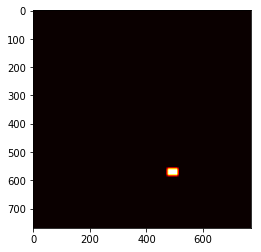

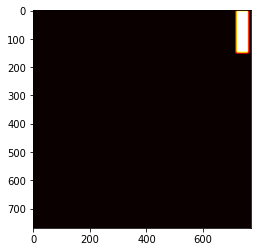

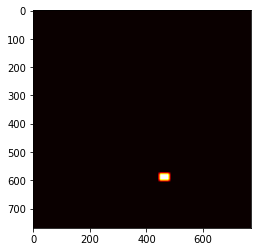

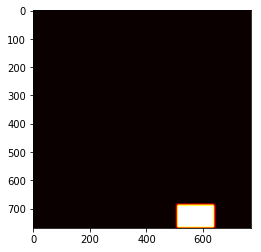

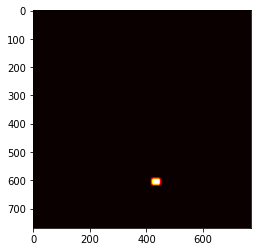

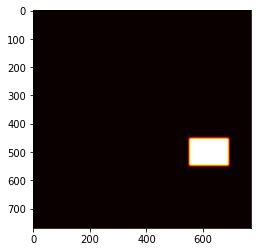

In [45]:
for i in range(6):
    plt.imshow(array[0,:,:,i], cmap='hot', interpolation='nearest')
    plt.show()

### let's look at the union

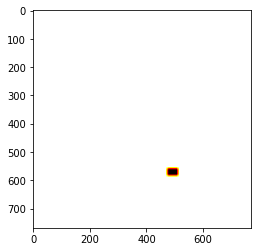

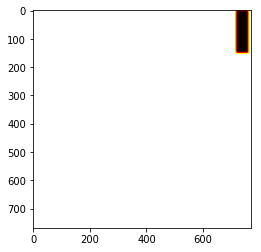

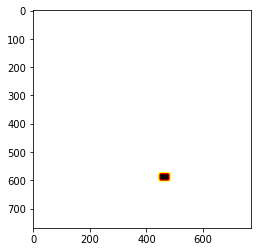

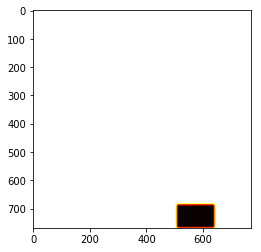

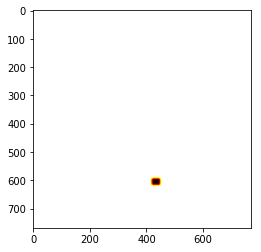

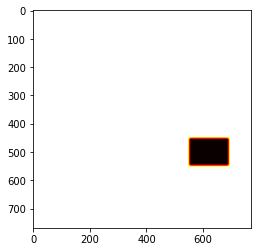

In [72]:
with tf.Session() as sess:
    array = union.eval(session=sess)
for i in range(6):
    plt.imshow(array[0,:,:,i], cmap='hot', interpolation='nearest')
    plt.show()

### Let's look at IOUs

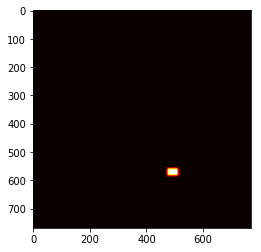

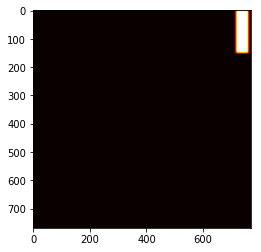

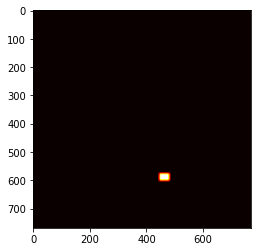

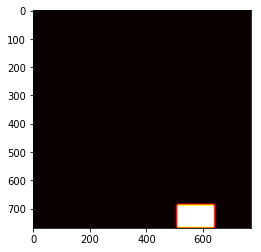

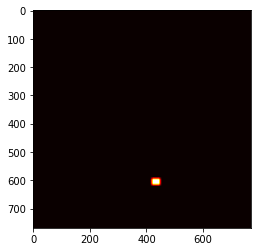

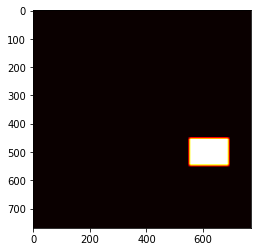

In [73]:
with tf.Session() as sess:
    array = ious.eval(session=sess)
for i in range(6):
    plt.imshow(array[0,:,:,i], cmap='hot', interpolation='nearest')
    plt.show()

In [ ]:
### here we calculate the max IOU and 

In [83]:
tfeval = max_iou_over_ground_truth
with tf.Session() as sess:
    array = tfeval.eval(session=sess)

[0.         0.00080351 0.0016083  0.0024144  0.00322179 0.00403049
 0.00484048 0.00565179 0.00646441 0.00727834 0.00809359 0.00891016
 0.00891016 0.00891016 0.00891016]
0.1753623188405797


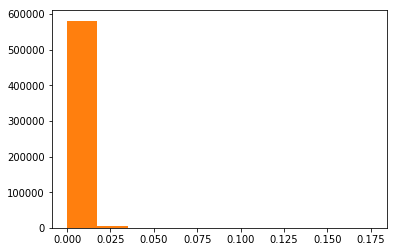

In [86]:
max_iou = array
print(max_iou[0,445:460,600])
print(np.max(max_iou))
plt.hist(max_iou.flatten())
plt.show()

In [87]:
max_iou.shape

(1, 768, 768)

In [80]:
labels = tf.greater(max_iou_over_ground_truth, 0.5)
tfeval = labels
with tf.Session() as sess:
    array = tfeval.eval(session=sess)

In [81]:
array[0,445:460,600]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

### for the regression, we need to know which boat we are looking at

In [88]:
tf.argmax(ious, axis=[1,2])

ValueError: Shape must be rank 0 but is rank 1 for 'ArgMax' (op: 'ArgMax') with input shapes: [1,768,768,6], [2].

In [15]:
# TESTER
def tester(test):
    # Intialize the Session
    sess = tf.Session()
    # Print the result
    print(sess.run(test))
    # Close the session
    sess.close()